In [ ]:
import pandas as pd, numpy as np, torch, evaluate
from datasets import Dataset, DatasetDict, ClassLabel, Features, Value
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as sklearn_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [ ]:

# Constants
CSV_PATH = "other/text_classification_from_lectures.csv"
SEP = ";"
TEXT_COL = "Text"
LABEL_COL = "Label"
MODEL_NAME = "distilbert/distilbert-base-multilingual-cased"

df = pd.read_csv(CSV_PATH, sep=SEP, dtype=str).dropna(subset=[TEXT_COL, LABEL_COL])

labels = sorted(df[LABEL_COL].unique())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
df["label_id"] = df[LABEL_COL].map(label2id)

label_counts = Counter(df[LABEL_COL])
print(f"Label distribution: {label_counts}")

plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


min_samples_per_class = 3
classes_to_augment = [label for label, count in label_counts.items() if count < min_samples_per_class]
print(f"Classes that need augmentation: {classes_to_augment}")

augmented_rows = []
for class_name in classes_to_augment:
    class_samples = df[df[LABEL_COL] == class_name].copy()
# Add augmented rows if we created any
if augmented_rows:
    augmented_df = pd.concat(augmented_rows)
    df = pd.concat([df, augmented_df]).reset_index(drop=True)
    print(f"Added {len(augmented_df)} augmented samples")
    new_label_counts = Counter(df[LABEL_COL])
    print(f"New label distribution: {new_label_counts}")

In [ ]:

train_df, test_df = sklearn_split(
    df, 
    test_size=0.15, 
    random_state=42, 
    stratify=df["label_id"]  
)

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")

train_counts = Counter(train_df[LABEL_COL])
test_counts = Counter(test_df[LABEL_COL])
print(f"Training distribution: {train_counts}")
print(f"Test distribution: {test_counts}")

train_dataset = Dataset.from_pandas(train_df[[TEXT_COL, "label_id"]], preserve_index=False)
test_dataset = Dataset.from_pandas(test_df[[TEXT_COL, "label_id"]], preserve_index=False)
ds = DatasetDict({"train": train_dataset, "test": test_dataset})

tok = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:

def tok_fn(batch):
    tokenized = tok(batch[TEXT_COL], truncation=True, padding='max_length', max_length=128)
    
    tokenized["labels"] = batch["label_id"] 
    return tokenized

In [ ]:

ds_tok = ds.map(tok_fn, batched=True, remove_columns=[TEXT_COL])

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df['label_id'].astype(int)),
    y=df['label_id'].astype(int)
)
print(f"Class weights: {class_weights}")


class_weights = np.array(class_weights)
for i, label in id2label.items():
    if label_counts[label] < 5:
        class_weights[i] *= 1.5  

print(f"Adjusted class weights: {class_weights}")

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(
    torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:

# Comprehensive metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Accuracy
    accuracy = evaluate.load("accuracy").compute(predictions=predictions, references=labels)
    
    # Calculate per-class metrics for multi-class problems
    result = {'accuracy': accuracy['accuracy']}
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average=None, labels=list(range(len(id2label)))
    )
    
    # Add metrics per class
    for i, class_name in id2label.items():
        result[f'precision_{class_name}'] = precision[i]
        result[f'recall_{class_name}'] = recall[i]
        result[f'f1_{class_name}'] = f1[i]
    
    # Add macro averages
    result['macro_precision'] = precision.mean()
    result['macro_recall'] = recall.mean()
    result['macro_f1'] = f1.mean()
    
    return result

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Data collator
data_collator = DataCollatorWithPadding(tok)

In [ ]:

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Override compute_loss to use class weights.
        Includes num_items_in_batch parameter to match Trainer's signature.
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Use custom weighted loss
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

In [ ]:

args = TrainingArguments(
    output_dir="models",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1", 
    greater_is_better=True,
    logging_dir="./logs",
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    warmup_steps=100,
)

trainer = CustomTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["test"],
    tokenizer=tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:

def predict_class(text):
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return id2label[predicted_class_id]

In [ ]:

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

predictions = trainer.predict(ds_tok["test"])
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, [id2label[i] for i in range(len(labels))], rotation=45)
plt.yticks(tick_marks, [id2label[i] for i in range(len(labels))])

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
trainer.save_model("models/final_model")

Label distribution: Counter({'metadata': 46, 'context': 43, 'example': 40, 'code': 32, 'formula': 29})


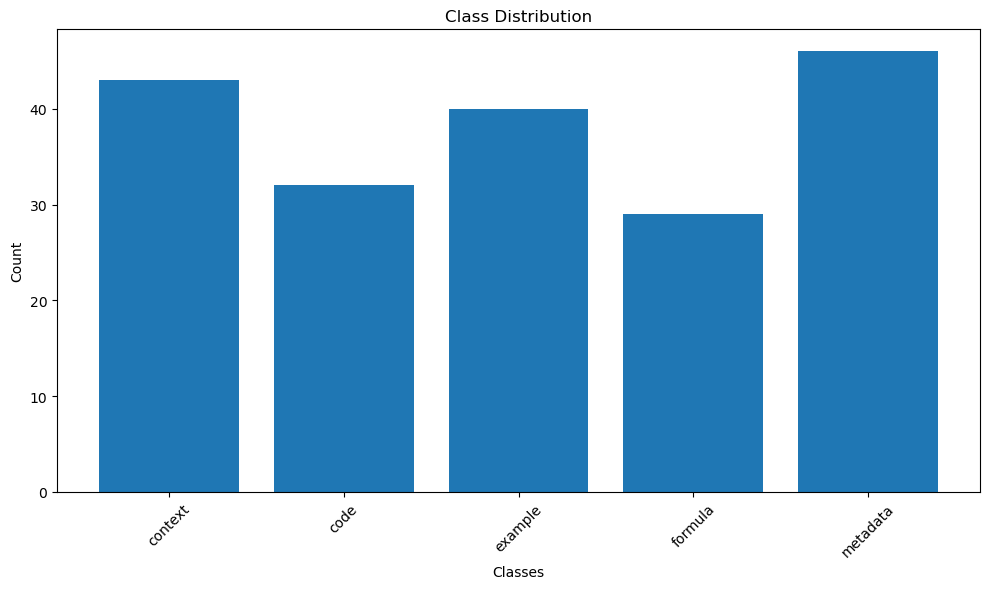

Classes that need augmentation: []
Training set: 161 samples
Test set: 29 samples
Training distribution: Counter({'metadata': 39, 'context': 36, 'example': 34, 'code': 27, 'formula': 25})
Test distribution: Counter({'metadata': 7, 'context': 7, 'example': 6, 'code': 5, 'formula': 4})


Map: 100%|██████████| 29/29 [00:00<00:00, 1855.97 examples/s]


Class weights: [1.1875     0.88372093 0.95       1.31034483 0.82608696]
Adjusted class weights: [1.1875     0.88372093 0.95       1.31034483 0.82608696]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Deea\AppData\Local\Temp\ipykernel_37756\86642667.py:170: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Code,Recall Code,F1 Code,Precision Context,Recall Context,F1 Context,Precision Example,Recall Example,F1 Example,Precision Formula,Recall Formula,F1 Formula,Precision Metadata,Recall Metadata,F1 Metadata,Macro Precision,Macro Recall,Macro F1
1,1.600500,1.588482,0.206897,0.185185,1.000000,0.312500,0.000000,0.000000,0.000000,1.000000,0.166667,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.237037,0.233333,0.119643
2,1.573100,1.517368,0.586207,0.333333,1.000000,0.500000,0.750000,0.428571,0.545455,1.000000,0.833333,0.909091,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.616667,0.652381,0.590909
3,1.484700,1.351643,0.655172,0.444444,0.800000,0.571429,0.666667,0.571429,0.615385,0.833333,0.833333,0.833333,0.666667,1.000000,0.800000,1.000000,0.285714,0.444444,0.722222,0.698095,0.652918
4,1.362500,1.075871,0.620690,0.400000,0.800000,0.533333,0.750000,0.428571,0.545455,0.833333,0.833333,0.833333,0.666667,1.000000,0.800000,0.666667,0.285714,0.400000,0.663333,0.669524,0.622424
5,1.015000,0.797267,0.793103,0.666667,0.800000,0.727273,1.000000,0.428571,0.600000,1.000000,0.833333,0.909091,0.666667,1.000000,0.800000,0.777778,1.000000,0.875000,0.822222,0.812381,0.782273
6,0.757700,0.604223,0.827586,0.800000,0.800000,0.800000,0.800000,0.571429,0.666667,1.000000,0.833333,0.909091,0.800000,1.000000,0.888889,0.777778,1.000000,0.875000,0.835556,0.840952,0.827929
7,0.521400,0.544990,0.827586,0.800000,0.800000,0.800000,0.714286,0.714286,0.714286,1.000000,0.833333,0.909091,0.800000,1.000000,0.888889,0.857143,0.857143,0.857143,0.834286,0.840952,0.833882
8,0.270500,0.622046,0.793103,0.750000,0.600000,0.666667,0.666667,0.571429,0.615385,1.000000,0.833333,0.909091,0.800000,1.000000,0.888889,0.777778,1.000000,0.875000,0.798889,0.800952,0.791006
9,0.188700,0.490052,0.862069,0.800000,0.800000,0.800000,0.833333,0.714286,0.769231,1.000000,0.833333,0.909091,0.800000,1.000000,0.888889,0.875000,1.000000,0.933333,0.861667,0.869524,0.860109
10,0.061100,0.599484,0.827586,0.666667,0.800000,0.727273,0.833333,0.714286,0.769231,1.000000,0.833333,0.909091,0.800000,1.000000,0.888889,0.857143,0.857143,0.857143,0.831429,0.840952,0.830325


D:\Programs\Anaconda\envs\RAGThesisEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation results: {'eval_loss': 0.4900519549846649, 'eval_accuracy': 0.8620689655172413, 'eval_precision_code': 0.8, 'eval_recall_code': 0.8, 'eval_f1_code': 0.8, 'eval_precision_context': 0.8333333333333334, 'eval_recall_context': 0.7142857142857143, 'eval_f1_context': 0.7692307692307693, 'eval_precision_example': 1.0, 'eval_recall_example': 0.8333333333333334, 'eval_f1_example': 0.9090909090909091, 'eval_precision_formula': 0.8, 'eval_recall_formula': 1.0, 'eval_f1_formula': 0.8888888888888888, 'eval_precision_metadata': 0.875, 'eval_recall_metadata': 1.0, 'eval_f1_metadata': 0.9333333333333333, 'eval_macro_precision': 0.8616666666666667, 'eval_macro_recall': 0.8695238095238096, 'eval_macro_f1': 0.8601087801087802, 'eval_runtime': 0.9814, 'eval_samples_per_second': 29.55, 'eval_steps_per_second': 1.019, 'epoch': 10.0}
Evaluation results: {'eval_loss': 0.4900519549846649, 'eval_accuracy': 0.8620689655172413, 'eval_precision_code': 0.8, 'eval_recall_code': 0.8, 'eval_f1_code': 0.8, '

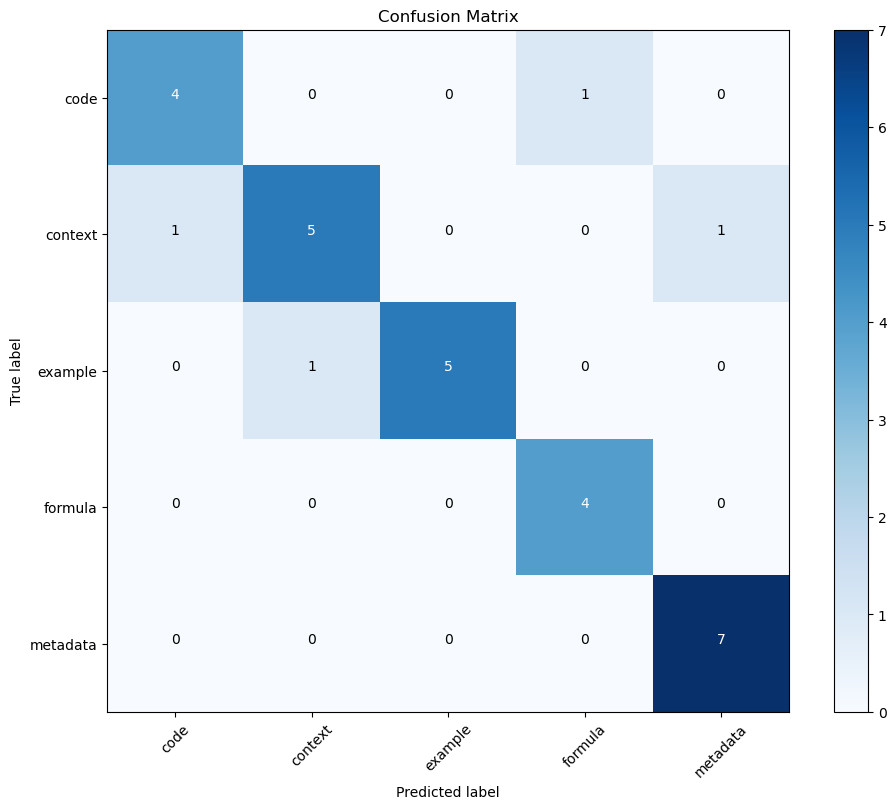

Example text for class 'code':
  Text: int find_max(const int *array, size_t len) {\n  int max = INT_MIN;\n  for (size_t i = 0; i < len; i+...
  Predicted class: code

Example text for class 'context':
  Text: TYPES OF KNOWLEDGE
 declarative knowledge  is  statements of fact .
- someone will win a Google
...
  Predicted class: context

Example text for class 'example':
  Text: Optimizing delivery routes for logistics companies is an example of route optimization....
  Predicted class: example

Example text for class 'formula':
  Text: The derivative of a function f(x) is defined as f'(x) = lim(h→0) [f(x+h) - f(x)] / h....
  Predicted class: formula

Example text for class 'metadata':
  Text: Thomas H. Cormen, Charles E. Leiserson, Ronald L. Rivest, Clifford Stein. Introduction to Algorithms...
  Predicted class: metadata



In [32]:

def predict_class(text):
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return id2label[predicted_class_id]

for label in labels:
    if label in train_df[LABEL_COL].values:
        example = train_df[train_df[LABEL_COL] == label][TEXT_COL].iloc[0]
        print(f"Example text for class '{label}':")
        print(f"  Text: {example[:100]}...")
        print(f"  Predicted class: {predict_class(example)}")
        print()